<a href="https://colab.research.google.com/github/eveugla/PyTorch_GB/blob/main/%D0%94%D0%97_10_%D0%A0%D0%A2_eveugla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os
import time

from google.colab import drive
from PIL import Image

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_file = '/content/drive/MyDrive/archive.zip'

z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())

['.config', 'leapGestRecog', 'drive', 'leapgestrecog', 'sample_data']


In [5]:
!pip install torchsummary

In [6]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.4 MB/s eta 0:00:00


In [7]:
! pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 34.2 MB/s eta 0:00:00


In [8]:
! unzip /content/drive/MyDrive/archive.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [9]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

In [10]:
DATA_ROOT = 'leapgestrecog/leapGestRecog'

In [11]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3),
                         tt.Resize([244, 244]),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor(),
                         ])

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([244, 244]),
                        tt.ToTensor(),
                        ])

In [12]:
tmp_ds = ImageFolder(os.path.join(DATA_ROOT, '00'))
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [13]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
  train_ds = ImageFolder(os.path.join(DATA_ROOT, dir), train_tfms)
  test_ds = ImageFolder(os.path.join(DATA_ROOT, dir), test_tfms)
  train_ds_list.append(train_ds)
  test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

In [14]:
len(train_ds)

20000

In [15]:
def digit_to_classname(digit):
  for idx, itm in enumerate(CLASSES_NAME):
    if idx == digit:
      return itm

In [16]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'01_palm': 2000, '02_l': 2000, '03_fist': 2000, '04_fist_moved': 2000, '05_thumb': 2000, '06_index': 2000, '07_ok': 2000, '08_palm_moved': 2000, '09_c': 2000, '10_down': 2000}


In [17]:
len_df = len(train_ds)
len_df

20000

In [18]:
torch.manual_seed(1)

val_split = 0.2
split = int(len_df * val_split)
indices = torch.randperm(len_df)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(16000, 4000)

In [19]:
train_ds[20][0].shape

torch.Size([3, 244, 244])

In [20]:
from collections import Counter
tmp_list = []
for _, cls in train_ds:
  tmp_list.append(digit_to_classname(cls))
cnt = Counter(tmp_list)
print(dict(cnt))

{'05_thumb': 1608, '02_l': 1609, '01_palm': 1587, '06_index': 1606, '04_fist_moved': 1610, '03_fist': 1590, '09_c': 1610, '07_ok': 1594, '08_palm_moved': 1594, '10_down': 1592}


In [21]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

torch.Size([3, 244, 244])
tensor(4) 05_thumb


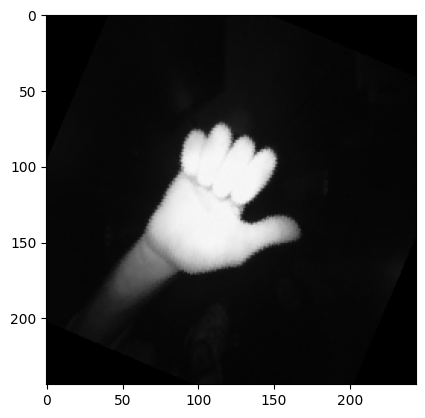

In [22]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [23]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

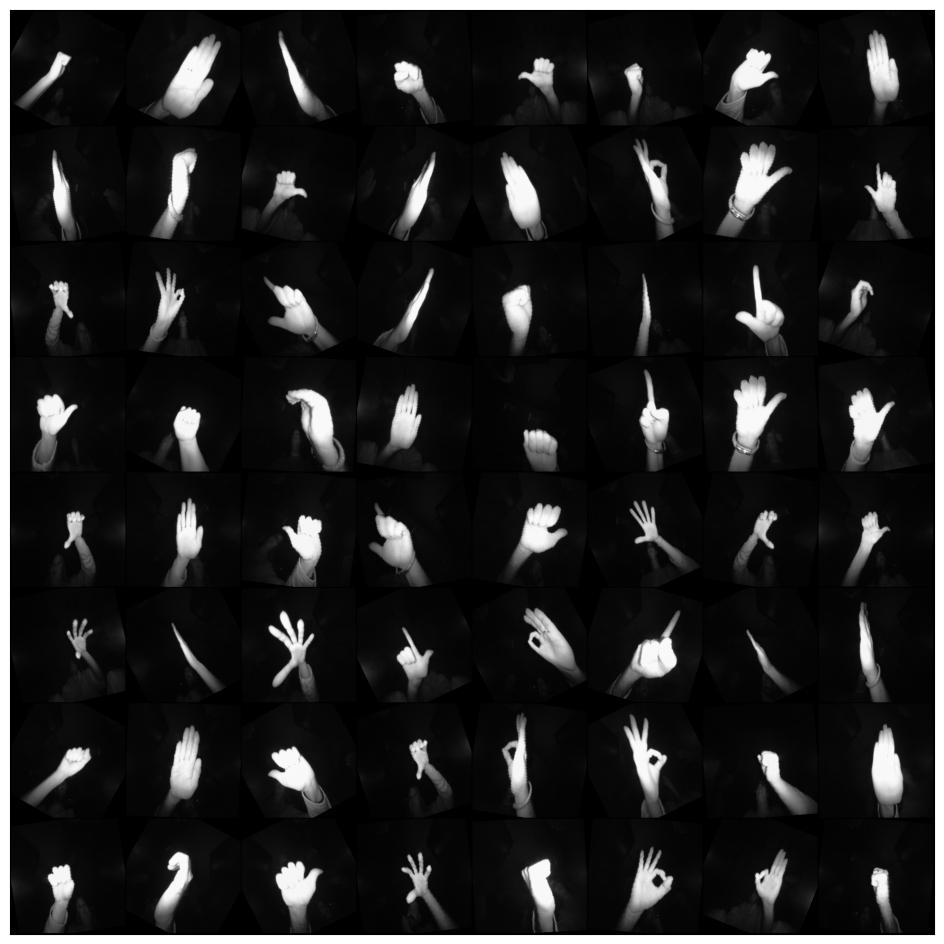

In [24]:
show_batch(train_dl)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
from torchvision.models import resnet50, ResNet50_Weights

In [27]:
resnet = resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.2MB/s]


In [28]:
summary(resnet.to(device), input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [29]:
for param in resnet.parameters():
    param.requires_grad = False

In [30]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME)) #10
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [32]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [33]:
from time import time

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()

        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}')
        torch.save(model.state_dict(), f'checkpoint_{correct_val / total_val * 100:.2f}')

    return model, train_losses, val_losses

In [34]:
print_every = 50
num_epoch = 10

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[10]. Batch [50]/[250]. Train loss 2.129. Train acc 37.094. Val loss 2.308. Val acc 19.400. Took 47.140 seconds
Epoch [1]/[10]. Batch [100]/[250]. Train loss 2.078. Train acc 36.047. Val loss 1.790. Val acc 54.050. Took 44.294 seconds
Epoch [1]/[10]. Batch [150]/[250]. Train loss 1.943. Train acc 43.188. Val loss 1.567. Val acc 55.325. Took 43.865 seconds
Epoch [1]/[10]. Batch [200]/[250]. Train loss 1.829. Train acc 48.531. Val loss 1.419. Val acc 59.700. Took 44.645 seconds
Epoch [1]/[10]. Batch [250]/[250]. Train loss 1.726. Train acc 52.850. Val loss 1.312. Val acc 62.000. Took 43.244 seconds
Epoch took 223.26072788238525
Epoch [2]/[10]. Batch [50]/[250]. Train loss 0.276. Train acc 58.906. Val loss 1.466. Val acc 56.825. Took 45.814 seconds
Epoch [2]/[10]. Batch [100]/[250]. Train loss 0.428. Train acc 65.109. Val loss 1.217. Val acc 72.150. Took 44.749 seconds
Epoch [2]/[10]. Batch [150]/[250]. Train loss 0.522. Train acc 68.688. Val loss 1.058. Val acc 79.100. Took 44.

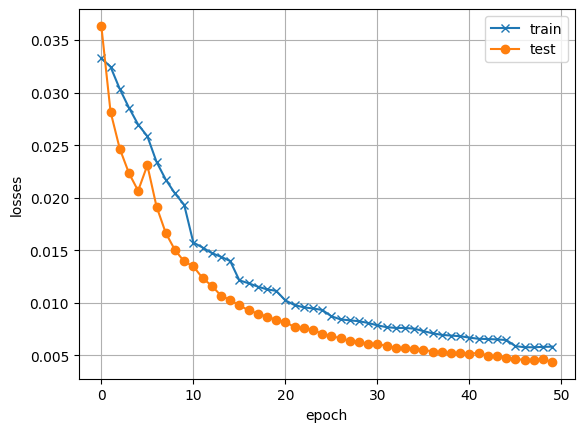

In [35]:
plt.plot(train_losses, '-x', label = f'train')
plt.plot(val_losses, '-o', label = 'test')
plt.xlabel('epoch')
plt.ylabel('losses');
plt.legend()
plt.grid()
plt.show()

In [36]:
resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=3
)

Epoch [1]/[3]. Batch [50]/[250]. Train loss 0.383. Train acc 90.312. Val loss 0.281. Val acc 92.950. Took 46.723 seconds
Epoch [1]/[3]. Batch [100]/[250]. Train loss 0.375. Train acc 91.047. Val loss 0.279. Val acc 93.000. Took 44.379 seconds
Epoch [1]/[3]. Batch [150]/[250]. Train loss 0.366. Train acc 91.417. Val loss 0.269. Val acc 93.525. Took 44.384 seconds
Epoch [1]/[3]. Batch [200]/[250]. Train loss 0.364. Train acc 91.453. Val loss 0.270. Val acc 93.275. Took 44.453 seconds
Epoch [1]/[3]. Batch [250]/[250]. Train loss 0.360. Train acc 91.619. Val loss 0.267. Val acc 93.250. Took 43.792 seconds
Epoch took 223.8537621498108
Epoch [2]/[3]. Batch [50]/[250]. Train loss 0.063. Train acc 90.531. Val loss 0.260. Val acc 92.950. Took 46.507 seconds
Epoch [2]/[3]. Batch [100]/[250]. Train loss 0.101. Train acc 91.344. Val loss 0.249. Val acc 93.925. Took 44.511 seconds
Epoch [2]/[3]. Batch [150]/[250]. Train loss 0.130. Train acc 91.646. Val loss 0.252. Val acc 93.550. Took 44.684 secon

In [37]:
torch.save(resnet.state_dict(), '/content/checkpoint_95.50')

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES_NAME = 10
resnet = resnet50(weights=None)
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=CLASSES_NAME) #10
resnet.fc = fc
resnet.load_state_dict(torch.load('/content/checkpoint_95.50', map_location=torch.device(device)))

<All keys matched successfully>

In [39]:
torch.save(resnet, '/content/checkpoint_95.50')

In [40]:
resnet = torch.load('/content/checkpoint_95.50')
resnet = resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

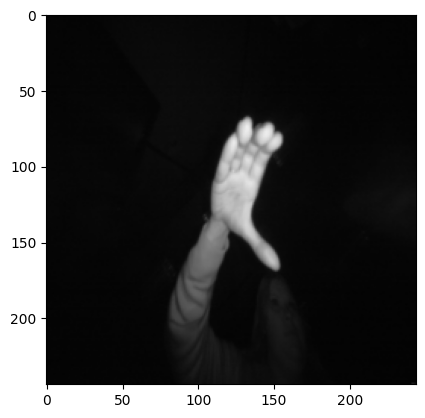

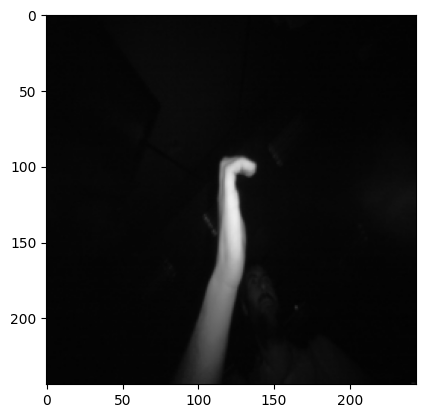

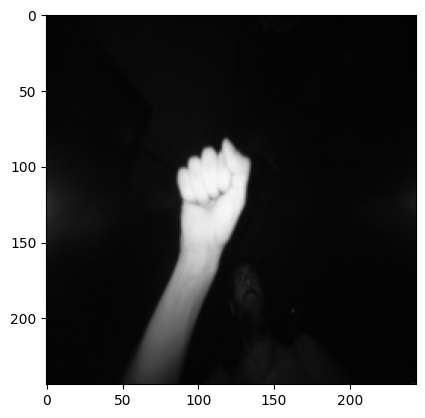

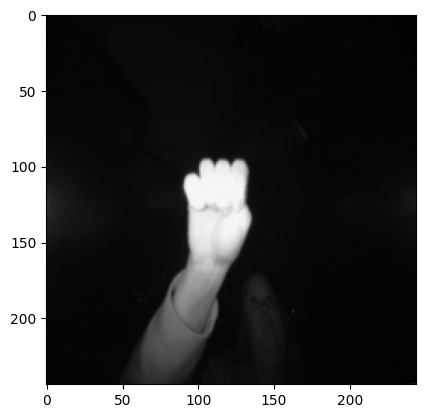

In [41]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = resnet(images)
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

In [42]:
!pip install facenet_pytorch

In [43]:
! pip install mediapipe

In [99]:
import cv2
from PIL import Image
from facenet_pytorch import MTCNN
import mediapipe as mp


class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn, filename):
        self.classes_name = ['01_palm',
                              '02_l',
                              '03_fist',
                              '04_fist_moved',
                              '05_thumb',
                              '06_index',
                              '07_ok',
                              '08_palm_moved',
                              '09_c',
                              '10_down']
        self.preprocess = tt.Compose([
                         tt.Resize([128, 128]),
                         tt.Grayscale(num_output_channels=3), # Картинки черно-белые
                         tt.ToTensor(),                       # Приведение к тензору
                         ])
        self.filename = filename
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = torch.load('/content/checkpoint_95.50')
        self.model.eval()

    def _draw(self, frame, boxes, probs, landmarks, gests):
        """
        Draw landmarks and boxes for each face detected
        """
        for box, prob, ld, gest in zip(boxes, probs, landmarks, gests):
            # Draw rectangle on frame
            cv2.rectangle(frame,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          (0, 0, 255),
                          thickness=2)

             # Show probability
            cv2.putText(frame,
                gest, (int(box[2]), int(box[3])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

            ld = ld.astype(np.int64)

             # Draw landmarks
            cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
            cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
            cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
            cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
            cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)

        return frame


    def digit_to_classname(self, digit):
        for idx, itm in enumerate(self.classes_name):
          if idx == digit:
            return itm

    @staticmethod
    def crop_hands(frame, hand_boxes):
        hands = []
        for i, hand_box in enumerate(hand_boxes):
            pad = int((hand_box[2] - hand_box[0]) / 4)
            h,w,c = frame.shape
            pad1 = pad if hand_box[1]-pad >= 0 else hand_box[1]
            pad2 = pad if hand_box[3]+pad <= h else h - hand_box[3]
            pad3 = pad if hand_box[0]-pad >= 0 else hand_box[0]
            pad4 = pad if hand_box[2]-pad <= w else w - hand_box[2]
            hands.append(frame[int(hand_box[1]-pad1):int(hand_box[3]+pad2),
                int(hand_box[0]-pad3):int(hand_box[2]+pad4), :])
        return hands

    @staticmethod
    def get_hands(img):
      mpHands = mp.solutions.hands
      hands = mpHands.Hands(False)
      npDraw = mp.solutions.drawing_utils

      results = hands.process(img)
      if results.multi_hand_landmarks:
          hand_boxes = []
          for handLms in results.multi_hand_landmarks:
              h,w,c = img.shape
              x_max = 0
              y_max = 0
              x_min = w
              y_min = h
              for lm in handLms.landmark:
                  x, y = int(lm.x * w), int(lm.y * h)
                  if x > x_max:
                      x_max = x
                  if x < x_min:
                      x_min = x
                  if y > y_max:
                      y_max = y
                  if y < y_min:
                      y_min = y
              hand_box = [x_min, y_min, x_max, y_max]
          hand_boxes.append(hand_box)
      return hand_boxes


    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """
        frame = cv2.imread(path_to_img)


        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        print(boxes)

        hand_boxes = self.get_hands(frame)
        hands = self.crop_hands(frame, hand_boxes)

        gests = []
        for hand in hands:
            hand = cv2.cvtColor(hand, cv2.COLOR_BGR2RGB)
            hand = Image.fromarray(hand)
            hand = self.preprocess(hand)
            # hand = TF.adjust_brightness(hand, 1.5)
            # hand = TF.adjust_contrast(hand, 1.5)
            hand = hand.to(device).float()
            gest = self.model(hand[None, ...])
            print(gest)
            gest = self.digit_to_classname(gest[0].argmax())
            gests.append(gest)

        # draw on frame
        self._draw(frame, boxes, probs, landmarks, gests)

        # Show the frame
        cv2.imwrite(self.filename, frame)

In [100]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  global hand_boxes
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

    mtcnn = MTCNN()

  fcd = FaceDetector(mtcnn, filename)

  fcd.run(filename)

  return filename

In [101]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

[[131.96188354492188 253.01600646972656 267.98004150390625
  428.6278991699219]]
local variable 'hand_boxes' referenced before assignment
